In [1]:
from torchvision import datasets, transforms
import torch

In [2]:
pca_components = 4

# Data Preparation

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('data', train=False,
                    transform=transform)
train_kwargs = {'batch_size': 4, 'shuffle': True, 'num_workers': 1, 'pin_memory': True}
test_kwargs = {'batch_size': 1024, 'shuffle': False, 'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [4]:
import numpy as np
from sklearn.decomposition import PCA

# Convert data loaders to numpy arrays for PCA
X_train = []
y_train = []
X_test = []
y_test = []

# Extract data from train loader
for data, target in train_loader:
    X_train.append(data.numpy().reshape(data.shape[0], -1))
    y_train.append(target.numpy())

# Extract data from test loader
for data, target in test_loader:
    X_test.append(data.numpy().reshape(data.shape[0], -1))
    y_test.append(target.numpy())

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Apply PCA
pca = PCA(n_components=pca_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# normalize each feature to [0, 1]
X_train_pca = (X_train_pca - X_train_pca.min(axis=0)) / (X_train_pca.max(axis=0) - X_train_pca.min(axis=0))
X_test_pca = (X_test_pca - X_test_pca.min(axis=0)) / (X_test_pca.max(axis=0) - X_test_pca.min(axis=0))

# Convert back to PyTorch tensors and create new data loaders
X_train_pca = torch.FloatTensor(X_train_pca)
X_test_pca = torch.FloatTensor(X_test_pca)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [5]:
X_train_pca[0:3]

tensor([[0.1950, 0.5747, 0.4928, 0.6509],
        [0.0765, 0.6817, 0.4988, 0.5545],
        [0.3866, 0.5364, 0.6901, 0.4771]])

In [6]:
y_train[0:10]

tensor([8, 8, 8, 9, 3, 5, 4, 1, 0, 9])

In [7]:
# only take items where y is 1 or 5
mask_train = (y_train == 1) | (y_train == 5)
mask_test = (y_test == 1) | (y_test == 5)
X_train_pca = X_train_pca[mask_train]
y_train = y_train[mask_train]
X_test_pca = X_test_pca[mask_test]
y_test = y_test[mask_test]

# convert y_train and y_test to 0 and 1 from 1 and 5
y_train = (y_train == 1).long()
y_test = (y_test == 1).long()

# Create TensorDataset
train_dataset = torch.utils.data.TensorDataset(X_train_pca, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test_pca, y_test)

# Create new data loaders with PCA-transformed data
train_loader_pca = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader_pca = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

# Print explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.4f}")

Explained variance ratio: [0.09704393 0.07096102 0.06169185 0.05389264]
Total variance explained: 0.2836


In [8]:
# smaller dataset with only 40 samples
small_train_dataset = torch.utils.data.TensorDataset(X_train_pca[:40], y_train[:40])
small_train_loader = torch.utils.data.DataLoader(small_train_dataset, **train_kwargs)
small_test_dataset = torch.utils.data.TensorDataset(X_test_pca[:40], y_test[:40])
small_test_loader = torch.utils.data.DataLoader(small_test_dataset, **test_kwargs)

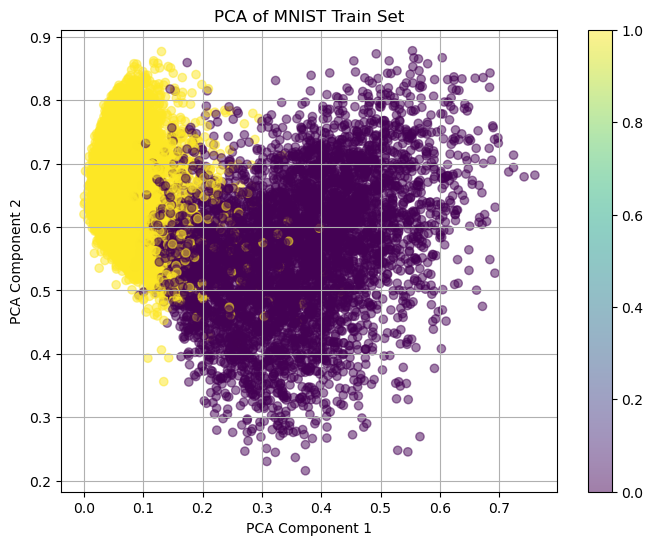

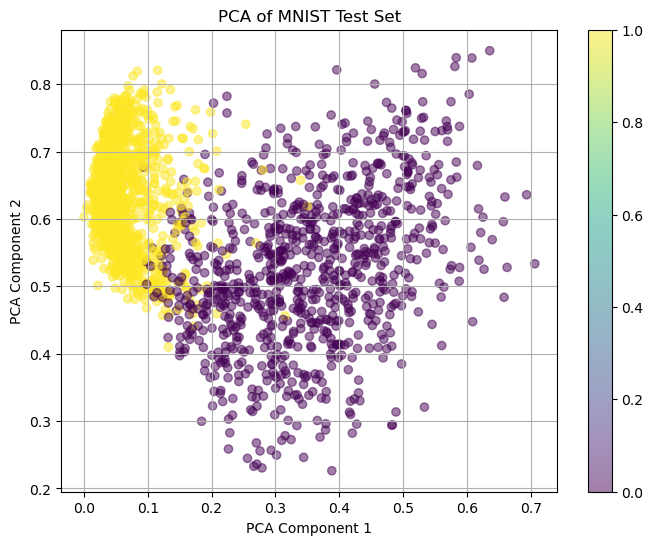

In [9]:
# visualize the results
import matplotlib.pyplot as plt

def plot_pca_components(X, y, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid()
    plt.show()

plot_pca_components(X_train_pca.numpy(), y_train.numpy(), 'PCA of MNIST Train Set')
plot_pca_components(X_test_pca.numpy(), y_test.numpy(), 'PCA of MNIST Test Set')

In [10]:
print(X_train_pca.shape)
print(X_test_pca.shape)

torch.Size([12163, 4])
torch.Size([2027, 4])


In [24]:
x_sample = X_train_pca[0]
y_sample = y_train[0]
print(f"Sample PCA data point: {x_sample}")
print(f"Sample label: {y_sample.item()}")

Sample PCA data point: tensor([0.3834, 0.5216, 0.7530, 0.6137])
Sample label: 0


# Pasqal Model Preparation

In [11]:
import torch
from torch import Tensor

from typing import Callable

from pulser import Sequence, Pulse, Register
from pulser.devices import MockDevice
from pulser.waveforms import BlackmanWaveform, RampWaveform, CustomWaveform, ConstantWaveform

from pulser_diff.backend import TorchEmulator
from pulser_diff.derivative import deriv_time, deriv_param
from pulser_diff.utils import IMAT, ZMAT, kron

import matplotlib.pyplot as plt
from scipy import interpolate

from pyqtorch.utils import SolverType
from pulser.register.register_layout import RegisterLayout

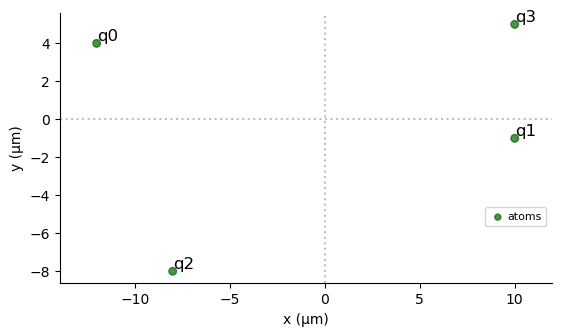

In [12]:
# Generating random coordinates
np.random.seed(42)  # Keeps results consistent between runs
positions = np.random.randint(0, 30, size=(pca_components, 2))
positions = positions - np.mean(positions, axis=0)
positions = torch.tensor(positions, requires_grad=True)
# positions = torch.tensor([[0, 0], [1, 0], [0, 1], [1, 1]], dtype=torch.float64, requires_grad=True)
# positions = positions - torch.mean(positions, axis=0)
# pos_q0 = torch.tensor([0.0, 0.0], requires_grad=True)
# pos_q1 = torch.tensor([1.0, 0.0], requires_grad=True)
# pos_q2 = torch.tensor([0.0, 1.0], requires_grad=True)
# pos_q3 = torch.tensor([1.0, 1.0], requires_grad=True)
# positions = torch.stack([pos_q0, pos_q1, pos_q2, pos_q3])
reg = Register({"q" + str(i): pos for i, pos in enumerate(positions)})
reg.draw()

In [13]:
# create sequence and declare channels
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")
seq.declare_channel("rydberg_local", "rydberg_local")

local_pulses_duration = 1000  # Duration of local pulses in ns
local_pulses_omega = [1.0] * pca_components  # Amplitude of local pulses
local_pulses_omega = torch.tensor(local_pulses_omega, dtype=torch.float32, requires_grad=True)
local_pulses_delta = [0.0] * pca_components  # Detuning of local pulses
local_pulses_delta = torch.tensor(local_pulses_delta, dtype=torch.float32, requires_grad=True)

# local pulses (1 pulse per qubit)
for i in range(pca_components):
    pulse_local = Pulse.ConstantPulse(local_pulses_duration, local_pulses_omega[i], local_pulses_delta[i], 0.0)
    seq.target(f"q{i}", channel="rydberg_local")
    seq.add(pulse_local, "rydberg_local")
    seq.declare_variable(f"omega_q{i}")
    seq.declare_variable(f"delta_q{i}")

# global pulse
global_pulse_duration = 1000  # Duration of global pulse in ns
global_pulse_omega = 1.0  # Amplitude of global pulse
global_pulse_omega = torch.tensor(global_pulse_omega, dtype=torch.float32, requires_grad=True)
global_pulse_delta = 0.0  # Detuning of global pulse
global_pulse_delta = torch.tensor(global_pulse_delta, dtype=torch.float32, requires_grad=True)
pulse_global = Pulse.ConstantPulse(global_pulse_duration, global_pulse_omega, global_pulse_delta, 0.0)
seq.add(pulse_global, "rydberg_global")
seq.declare_variable("omega_global")
seq.declare_variable("delta_global")

VariableItem(var=Variable(name='delta_global', dtype=<class 'float'>, size=1), key=0)

In [14]:
local_pulses_omega[0]

tensor(1., grad_fn=<SelectBackward0>)

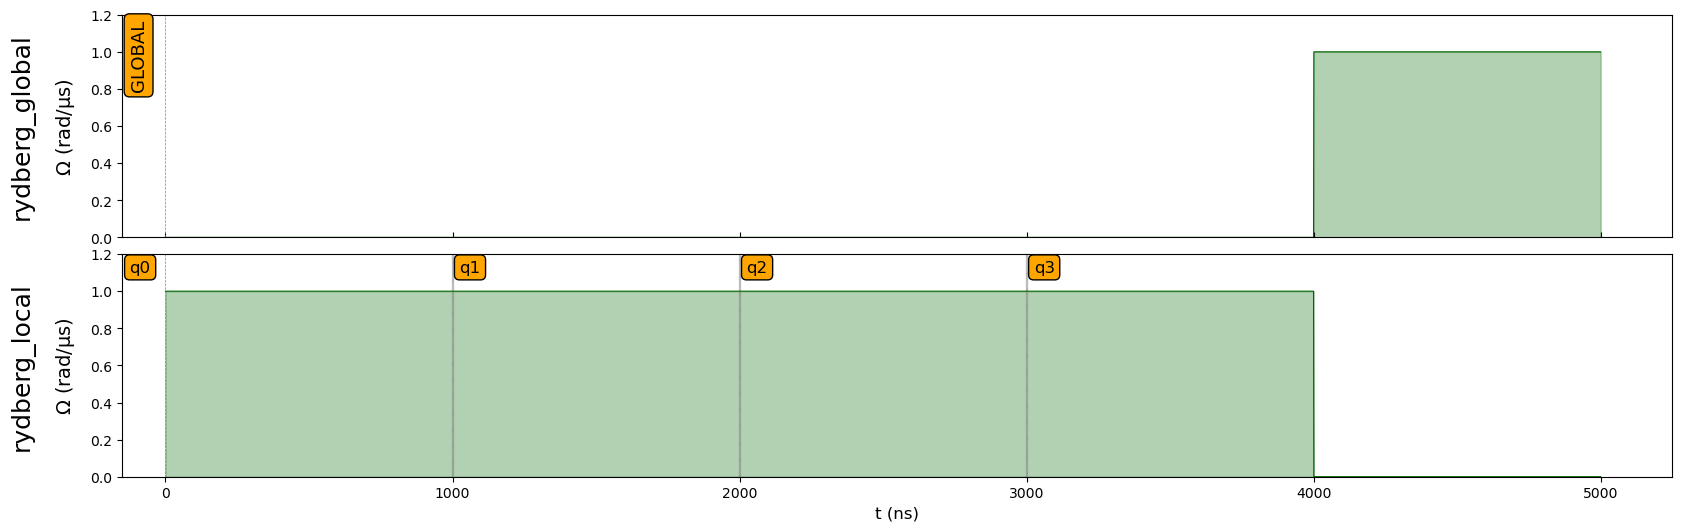

In [15]:
seq.draw()

In [16]:
sim = TorchEmulator.from_sequence(seq, sampling_rate=0.1)
results = sim.run(time_grad=True, dist_grad=True, solver=SolverType.DP5_SE)

In [32]:
def state_to_output(state: Tensor) -> Tensor:
    """
    Convert the final state of the system to a binary output.
    Here we assume that the output is 1 if the magnetization is positive,
    and 0 if it is negative.
    """
    magnetization = state.real.mean(dim=0)
    n_qubits = magnetization.shape[0]

    # Normalize the magnetization to [0, 1]
    out = (magnetization + n_qubits) / (2 * n_qubits)
    return out

In [33]:
state_to_output(results.states[-1])

tensor([0.4548], dtype=torch.float64, grad_fn=<DivBackward0>)

In [98]:
# now all in one function
def run_model(x: Tensor, positions: Tensor, local_pulses_omega: Tensor, local_pulses_delta: Tensor,
              global_pulse_omega: Tensor, global_pulse_delta: Tensor, draw_reg_seq:bool = True) -> Tensor:
    """
    Run the model with the given parameters and return the output.
    Args:
        x (Tensor): Input data, PCA components.
        positions (Tensor): Positions of the qubits in the register.
        local_pulses_omega (Tensor): Amplitudes of the local pulses. (shape: (pca_components,))
        local_pulses_delta (Tensor): Detunings of the local pulses. (shape: (pca_components,))
        global_pulse_omega (Tensor): Amplitude of the global pulse. (shape: ())
        global_pulse_delta (Tensor): Detuning of the global pulse. (shape: ())
    """
    reg = Register({"q" + str(i): pos for i, pos in enumerate(positions)})
    seq = Sequence(reg, MockDevice)
    seq.declare_channel("rydberg_global", "rydberg_global")
    seq.declare_channel("rydberg_local", "rydberg_local")

    # embed PCA components into the register through local pulses
    # x is already in the range [0, 1] due to normalization
    embed_pulse_duration = 500 # ns
    for i in range(pca_components):
        pulse_local = Pulse.ConstantPulse(embed_pulse_duration, 1000*x[i]*np.pi / embed_pulse_duration, 0.0, 0.0)  # Use x[i] as the amplitude
        seq.target(f"q{i}", channel="rydberg_local")
        seq.add(pulse_local, "rydberg_local")

    # local pulses
    local_pulse_duration = 500  # ns
    for i in range(pca_components):
        pulse_local = Pulse.ConstantPulse(local_pulse_duration, 
                                          local_pulses_omega[i]*np.pi*1000/local_pulse_duration, 
                                          local_pulses_delta[i]*np.pi*1000/local_pulse_duration,
                                          0.0)
        seq.target(f"q{i}", channel="rydberg_local")
        seq.add(pulse_local, "rydberg_local")
        seq.declare_variable(f"omega_q{i}")
        seq.declare_variable(f"delta_q{i}")

    # global pulse
    global_pulse_duration = 500 # ns
    pulse_global = Pulse.ConstantPulse(global_pulse_duration, 
                                       global_pulse_omega*np.pi*1000/global_pulse_duration, 
                                       global_pulse_delta*np.pi*1000/global_pulse_duration,
                                       0.0)
    seq.add(pulse_global, "rydberg_global")
    seq.declare_variable("omega_global")
    seq.declare_variable("delta_global")

    if draw_reg_seq:
        reg.draw()
        seq.draw()

    sim = TorchEmulator.from_sequence(seq, sampling_rate=0.1)
    results = sim.run(time_grad=True, dist_grad=True, solver=SolverType.DP5_SE)

    return state_to_output(results.states[-1])

In [99]:
np.random.seed(42)  # Keeps results consistent between runs
positions = np.random.randint(0, 30, size=(pca_components, 2))
positions = positions - np.mean(positions, axis=0)
positions = torch.tensor(positions, requires_grad=True)
print(positions)

local_pulses_omega = torch.tensor([1.0] * pca_components, dtype=torch.float32, requires_grad=True)
local_pulses_delta = torch.tensor([0.0] * pca_components, dtype=torch.float32, requires_grad=True)
global_pulse_omega = torch.tensor(1.0, dtype=torch.float32, requires_grad=True)
global_pulse_delta = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

# out = run_model(X_train_pca[0], positions, local_pulses_omega, local_pulses_delta, global_pulse_omega, global_pulse_delta)

tensor([[-12.,   4.],
        [ 10.,  -1.],
        [ -8.,  -8.],
        [ 10.,   5.]], dtype=torch.float64, requires_grad=True)


In [ ]:
# define loss function and optimizer
loss_fn = torch.nn.MSELoss()
parameters = [positions, local_pulses_omega, local_pulses_delta, global_pulse_omega, global_pulse_delta]
optimizer = torch.optim.Adam(parameters, lr=0.01)

In [103]:
from tqdm import tqdm
epochs = 2
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for i_batch, batch in enumerate(small_train_loader):
        print(f"Batch {i_batch+1}/{len(small_train_loader)}")
        x_batch, y_batch = batch
        optimizer.zero_grad()
        l = torch.tensor(0.0, requires_grad=False)
        for i in range(len(x_batch)):
            print(f"Processing sample {i+1}/{len(x_batch)}", end='\r')
            out = run_model(x_batch[i], positions, local_pulses_omega, local_pulses_delta, global_pulse_omega, global_pulse_delta, draw_reg_seq=False)
            loss = loss_fn(out, y_batch[i:i+1].to(torch.float64))
            l += loss
        l /= len(x_batch)
        l.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {l.item()}")

Epoch 1/2
Batch 1/10
Batch 2/10 sample 4/4
Batch 3/10 sample 4/4
Batch 4/10 sample 4/4
Batch 5/10 sample 4/4
Batch 6/10 sample 4/4
Batch 7/10 sample 4/4
Batch 8/10 sample 4/4
Batch 9/10 sample 4/4
Batch 10/10sample 4/4
Epoch 1, Loss: 0.21438409388065338
Epoch 2/2
Batch 1/10
Batch 2/10 sample 4/4
Batch 3/10 sample 4/4
Batch 4/10 sample 4/4
Batch 5/10 sample 4/4
Batch 6/10 sample 4/4
Batch 7/10 sample 4/4
Batch 8/10 sample 4/4
Batch 9/10 sample 4/4
Batch 10/10sample 4/4
Epoch 2, Loss: 0.2817898392677307
